<a href="https://colab.research.google.com/github/alexweltgeist/twitter_bitcoin/blob/main/Sentiment_Analysis_with_CNN_v04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textsearch
import nltk
nltk.download('punkt')

     |████████████████████████████████| 286kB 7.6MB/s 
     |████████████████████████████████| 327kB 40.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85402 sha256=4822fff8ffcc5ef5c726cd31e713d29c07feb1e537b5372d9ec1278fd626ea58
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [146]:
dataset = pd.read_csv('/content/all_tweets_with_lable.csv', sep=',', header = 0)
dataset = dataset[dataset['lable'] != 'Neutral']
dataset.head()
#dataset.count()

,text,lable
1,RT @BitcoinMagazine: Elon Musk taking a honest...,Positive
2,"RT @Daily_Swap: Remember in 2008 and 2009, the...",Positive
3,Breaking news !!!sent 3.000 #doge got back 30....,Positive
5,Thanks #doge!! + 105 000 instant ! Amazing $do...,Positive
6,It's an amazing project. Keep it up. I have pa...,Positive


In [147]:
total_rows = dataset.count
print (total_rows)

<bound method DataFrame.count of                                                    text     lable
1     RT @BitcoinMagazine: Elon Musk taking a honest...  Positive
2     RT @Daily_Swap: Remember in 2008 and 2009, the...  Positive
3     Breaking news !!!sent 3.000 #doge got back 30....  Positive
5     Thanks #doge!! + 105 000 instant ! Amazing $do...  Positive
6     It's an amazing project. Keep it up. I have pa...  Positive
...                                                 ...       ...
9994  RT @ICOAnnouncement: New Featured Project DuiC...  Positive
9995  @johnkvallis He's been around since at least 2...  Negative
9996  RT @GemBitesCom: LAST CHANCE TO BUY #PRESALE! ...  Positive
9998  Wrapped Bitcoin $WBTC Price IDR: Rp 549,005,07...  Positive
9999  RT @ICOAnnouncement: New Featured Project DuiC...  Positive

[6025 rows x 2 columns]>


In [148]:
# build train and test datasets
reviews = dataset['text'].values
sentiments = dataset['lable'].values

train_reviews = reviews[:4820]
train_sentiments = sentiments[:4820]

test_reviews = reviews[4821:]
test_sentiments = sentiments[4821:]

In [149]:
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in docs:
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc) # the    dog  => the dog
        doc = doc.strip() 
        norm_docs.append(doc)
    return norm_docs

In [150]:
norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

In [151]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [152]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('hand', 6092), ('<PAD>', 0), 1)

In [153]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [154]:
len(train_sequences[0])

12

In [155]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=6093
Number of Documents=4820


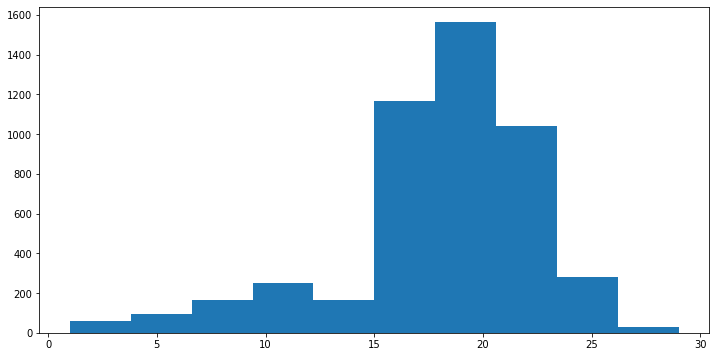

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

In [157]:
MAX_SEQUENCE_LENGTH = 26

In [159]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((4820, 26), (1204, 26))

In [160]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   2, 181,  37,  43, 606,  13, 747, 343,  47,   4, 138, 301],
      dtype=int32)

In [161]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [162]:
le.fit(train_sentiments)
list(le.classes_)

['Negative', 'Positive']

In [163]:
y_train = le.transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [164]:
print(y_train)
print(len(y_train))
print(y_test)
print(len(y_test))

[1 1 1 ... 1 1 0]
4820
[1 1 1 ... 1 1 1]
1204


Prepare the Model

In [165]:
VOCAB_SIZE = len(t.word_index)

In [166]:
VOCAB_SIZE

6093

In [167]:
EMBED_SIZE = 100
EPOCHS=15
BATCH_SIZE=128

In [168]:
# create the model
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 
                    EMBED_SIZE, 
                    input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 26, 100)           609300    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 26, 128)           51328     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 13, 64)            32832     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 6, 32)             8224      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 3, 32)            

Model Training

In [169]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
history = model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
 #         callbacks=[es], 
          verbose=1)

Epoch 1/15
34/34 [==============================] - 2s 29ms/step - loss: 0.4183 - accuracy: 0.8096 - val_loss: 0.1629 - val_accuracy: 0.9398
Epoch 2/15
34/34 [==============================] - 0s 11ms/step - loss: 0.0659 - accuracy: 0.9740 - val_loss: 0.1801 - val_accuracy: 0.9295
Epoch 3/15
34/34 [==============================] - 0s 12ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.1640 - val_accuracy: 0.9419
Epoch 4/15
34/34 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.1545 - val_accuracy: 0.9627
Epoch 5/15
34/34 [==============================] - 0s 12ms/step - loss: 2.6853e-04 - accuracy: 1.0000 - val_loss: 0.1751 - val_accuracy: 0.9585
Epoch 6/15
34/34 [==============================] - 0s 12ms/step - loss: 1.1940e-04 - accuracy: 1.0000 - val_loss: 0.1902 - val_accuracy: 0.9606
Epoch 7/15
34/34 [==============================] - 0s 12ms/step - loss: 5.6973e-05 - accuracy: 1.0000 - val_loss: 0.2050 - val_accuracy: 0.9606
E

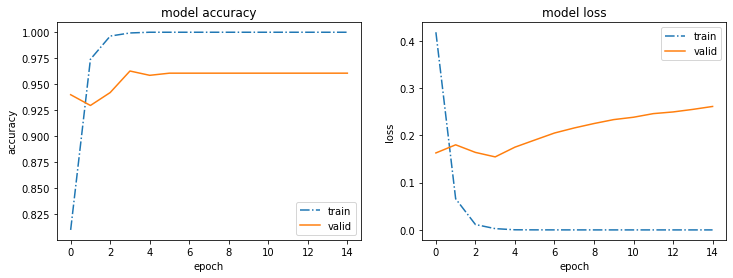

In [170]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

Model Evaluation

In [171]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

38/38 [==============================] - 0s 4ms/step - loss: 0.4838 - accuracy: 0.9377
Accuracy: 93.77%


In [172]:
predictions = model.predict(X_test)
predictions[200:210]

array([[5.378354e-04],
       [1.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [9.999999e-01],
       [1.000000e+00]], dtype=float32)

In [173]:
predictions = ['Positive' if item == 1 else 'Negative' for item in predictions]
predictions[:10]

['Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative']

In [174]:
test_sentiments

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [175]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    Negative       0.55      0.99      0.71       286
    Positive       0.99      0.75      0.85       918

    accuracy                           0.81      1204
   macro avg       0.77      0.87      0.78      1204
weighted avg       0.89      0.81      0.82      1204



,negative,positive
negative,282,4
positive,230,688
